<a href="https://colab.research.google.com/github/mantzaris/teddyCode/blob/main/Graphical_NN_10_13_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [2]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.7.1" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Plots"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [3]:
import Pkg; Pkg.add("InvertedIndices")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [4]:
using Plots
using LinearAlgebra
using BenchmarkTools
import Random
using InvertedIndices

In [17]:
using InvertedIndices
using Plots
using LinearAlgebra
using BenchmarkTools
import Random

function make_mtrx(dimentions, list_1, list_2)
  m = zeros(dimentions, dimentions)
  for i in list_1
    for j in list_2
      m[i, j] = 1
    end
  end
  return m
end


function get_zeros_non_zeros(mtrx, x_dim, y_dim)
  s = 0
    for i in range(1, x_dim)
      for j in range(1, y_dim)
        if (a[i, j] == 0.0)
          s = s + 1
        end
      end
    end
    println("Zeros: $s and Non-zeros: ", x_dim * y_dim - s)
  return s
end

function random_matrix(a, b, x_dim, y_dim)
  Random.seed!(1234)
  mtrx = rand(a:b, x_dim, y_dim )
  print(mtrx)
  return mtrx
end

function get_each_element(mtrx, x_dim, y_dim)
  for i in range(1, x_dim)
    for j in range(1, y_dim)
     print("mtrx[$i, $j]  = ", mtrx[i, j], "\n")
    end
  end
end

function A2S(AdjMat)
    AdjMat += I #add the identity to the diagonal, add self-loops
    diag = Diagonal(vec(sum(AdjMat,dims=2) .^ (-1/2)))
    return (diag) * AdjMat * (diag) #return the normalized S matrix
end

function initial_matrix(a_dim, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim)
  a = random_matrix(a_down_lim, a_up_lim, a_dim, a_dim)
  aj = A2S(a)
  x = random_matrix(x_down_lim, x_up_lim, a_dim, x_y_dim)
  th = random_matrix(th_down_lim, th_up_lim, x_y_dim, th_y_dim)
  Final = aj * x * th  
  return a, aj, x, th, Final
end



function reduce_size(a, x, th, n_col_row_to_reduce)
  x_dim = size(a, 1)
  y_dim = size(a, 2)
  a_reduced = a[Not(x_dim - n_col_row_to_reduce: end), Not(y_dim - n_col_row_to_reduce : end)]
  aj_reduced = A2S(a_reduced)
  x_reduced = x[Not(x_dim - n_col_row_to_reduce: end), :]
  Final_reduced = aj_reduced * x_reduced * th
  return Final_reduced
  end


function mae(mtrx, mtrx_reduced)
  x = size(mtrx_reduced, 1)
  y = size(mtrx_reduced, 2)
  s = 0
  for i in range(1, x)
    for j in range(1, y)
      s = s + abs(mtrx[i, j] - mtrx_reduced[i, j])
    end
  end
  mae = sqrt(s/(x*y))
  return mae 
  end
  


function total_error(n_drop_row_col, a_dims, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim )
  mean_average_error = Vector{Float64}()
  a = initial_matrix(a_dims, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim)[1]
  aj = initial_matrix(a_dims, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim)[2]
  x = initial_matrix(a_dims, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim)[3]
  th = initial_matrix(a_dims, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim)[4]
  Final = initial_matrix(a_dims, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim)[5]
  for i in range(-1, n_drop_row_col)
    F1 = reduce_size(a, x, th, i)
    MAE = mae(Final, F1)
    append!(mean_average_error,MAE)
  end
  skip = collect(-1: n_drop_row_col)
  return mean_average_error, skip
  end

 function split_alpha_matrix(a_mtrx, n_lines_to_split)
  x = size(a_mtrx, 1)
  y = size(a_mtrx, 2)
  n = div(x, n_lines_to_split)
  dictionary = Dict()
  count = 1
  k = 1
  for i in range(1, n_lines_to_split)
    z = 1
    for j in range(1, n_lines_to_split)
      dictionary["a_$count"] = a_mtrx[k: k + n - 1, z: j*n ]
      count = count + 1
      z = z + n
    end
    k = k + n
  end
  #show(stdout, "text/plain", dictionary["a_1"])
  return(dictionary)
end


function split_x_matrix(x_mtrx, n_lines_to_split)
  x = size(x_mtrx, 1)
  n = div(x, n_lines_to_split)
  dictionary = Dict()
  z = 1
  for i in range(1, n_lines_to_split)
    dictionary["x_$i"] = x_mtrx[z : z + n - 1 , 1:end]
    z = z + n
  end
  #show(stdout, "text/plain", dictionary["x_3"])
  return(dictionary)
  end 

  function multiply_splited(a_dim, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim, n_lines_to_split)
  a_mtrx = initial_matrix(a_dim, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim)[1]
  aj_mtrx = initial_matrix(a_dim, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim)[2]
  x_mtrx = initial_matrix(a_dim, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim)[3]
  th_mtrx = initial_matrix(a_dim, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim)[4]
  final_mtrx = initial_matrix(a_dim, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim)[5]

  a_splited = split_alpha_matrix(a_mtrx, n_lines_to_split)
  x_splited = split_x_matrix(x_mtrx, n_lines_to_split)
  aj_splited = Dict()
  print("\n")
  for i in range(1, length(a_splited))
    aj_splited["aj_$i"] = A2S(a_splited["a_$i"])
  end
  print("\n")
  #show(stdout, "text/plain", aj_splited)
  final_mtrx_splited = Dict()
  k = 1
  while k <= length(a_splited)
    for i in range(1, length(x_splited))
      final_mtrx_splited["Fin_$k"] = a_splited["a_$k"] * x_splited["x_$i"] * th
      k = k + 1
    end
  end
return(final_mtrx_splited)
end

multiply_splited (generic function with 1 method)

In [ ]:
error = total_error(200, 1000, 0, 10, 10, -4, 4, 5, -2, 2)[1]
skip = total_error(200, 1000, 0, 10, 10, -4, 4, 5, -2, 2)[2]


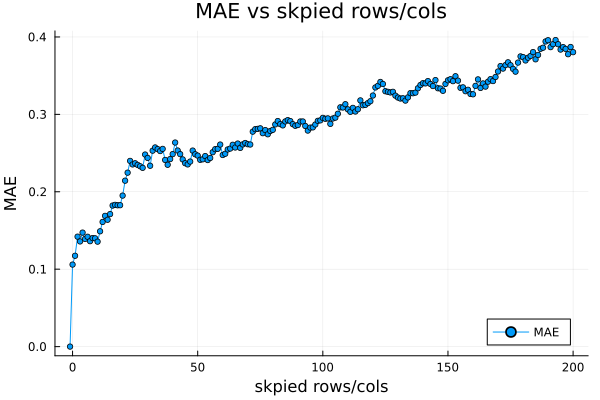

In [7]:
plot(skip, # x-axis
    error, # yaxis
    markershape=:circle, 
    markersize=3,
    title = "MAE vs skpied rows/cols",
    xlabel = "skpied rows/cols",
    label = "MAE",
    legend=:bottomright,
    ylabel = "MAE")

In [ ]:
a = initial_matrix(80, 0, 150, 20, -4, 4, 5, -2, 2)[1]
aj = initial_matrix(80, 0, 150, 20, -4, 4, 5, -2, 2)[2]
x = initial_matrix(80, 0, 150, 20, -4, 4, 5, -2, 2)[3]
th = initial_matrix(80, 0, 150, 20, -4, 4, 5, -2, 2)[4]
final = initial_matrix(80, 0, 150, 20, -4, 4, 5, -2, 2)[5]


In [18]:
multiply_splited(80, 0, 150, 20, -4, 4, 5, -2, 2, 3)

[49 52 105 101 29 82 115 144 84 97 60 136 55 75 59 102 138 143 42 126 105 77 131 28 109 122 41 140 136 45 141 55 9 56 88 100 73 72 116 118 40 13 91 34 100 24 25 119 131 71 84 89 97 141 88 10 65 99 108 50 29 39 127 69 18 118 15 5 98 18 32 61 30 55 133 17 123 79 18 24; 82 123 23 73 57 26 49 37 55 85 19 25 113 35 140 53 116 64 83 105 92 118 103 126 114 63 150 46 34 128 22 53 72 138 111 106 123 91 59 104 120 64 103 91 83 77 19 44 91 145 51 133 118 109 67 55 36 58 122 129 51 0 98 140 86 128 79 22 67 98 91 120 62 86 84 10 53 143 132 103; 33 119 111 3 37 65 65 136 150 53 91 24 144 131 89 91 69 61 61 82 68 123 2 73 86 6 116 23 132 50 20 137 91 35 36 24 28 47 81 19 2 30 85 105 104 15 9 11 82 129 32 30 45 78 88 133 116 91 99 105 10 92 98 62 131 116 79 28 141 98 47 38 143 129 12 23 20 83 104 14; 135 146 76 132 148 138 75 144 141 48 38 24 6 137 146 21 121 8 104 128 27 78 28 13 24 106 127 15 121 131 31 113 69 139 73 74 42 23 5 37 45 54 52 149 58 108 27 49 63 12 51 13 129 98 19 23 55 10 135 127 131 

Dict{Any, Any} with 9 entries:
  "Fin_2" => [-13174 -630 … -7634 -3433; -18282 -3976 … -2501 -5196; … ; -18462…
  "Fin_8" => [-15546 2022 … -5588 -5210; -10098 1247 … -4344 -2265; … ; -16870 …
  "Fin_9" => [8766 -3377 … -9407 5513; 73 -3203 … -8569 7886; … ; 937 -877 … -1…
  "Fin_6" => [8373 -70 … -11915 11732; 1037 -4658 … -7703 2088; … ; 8700 -7893 …
  "Fin_3" => [13788 -6063 … -14076 12357; 6678 -2843 … -15428 11590; … ; 7900 -…
  "Fin_5" => [-7435 -2510 … -1470 -945; -14079 6781 … 339 -1172; … ; -7386 2657…
  "Fin_4" => [7391 -1934 … -6799 5362; 7206 716 … -10256 10142; … ; 9121 -4196 …
  "Fin_1" => [7891 -2657 … -13263 7996; 11312 -3126 … -9107 4898; … ; 9707 -336…
  "Fin_7" => [7300 -5110 … -23788 9323; 9836 -767 … -5783 10816; … ; 8829 -6412…

# Need Help?

* Learning: https://julialang.org/learning/
* Documentation: https://docs.julialang.org/
* Questions & Discussions:
  * https://discourse.julialang.org/
  * http://julialang.slack.com/
  * https://stackoverflow.com/questions/tagged/julia

If you ever ask for help or file an issue about Julia, you should generally provide the output of `versioninfo()`.

Add new code cells by clicking the `+ Code` button (or _Insert_ > _Code cell_).

Have fun!

<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />